In [2]:
!pip install gcm-filters -q

In [3]:
!pip install gsw -q

In [4]:
!pip install numpy_groupies -q

In [5]:
!pip install xrft --upgrade -q

In [6]:
!pip install sklearn_xarray --upgrade -q

# Dask start

In [7]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:37409")

# Import

In [8]:
import sys
sys.path.insert(1, '..')

In [25]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
#import xrft_module
import xesmf as xe
import xgcm

In [10]:
import sklearn.linear_model
from sklearn.pipeline import make_pipeline, make_union

from sklearn_xarray import wrap
from sklearn.preprocessing import StandardScaler

In [11]:
# import importlib
# importlib.reload(xrft)

# Plotting params

In [12]:
#%matplotlib widget
%matplotlib inline

In [13]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [14]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

Choose cases

In [15]:
data=[dict() for i in range(6)]

In [16]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR sum'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES wint'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES sum'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED wint'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED sum'})

## eNATL60

In [17]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [18]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,100),y=y_slice,x=x_slice) 
coord_slice = dict(y=y_slice,x=x_slice)

In [19]:
nb_of_time_chunks = 4

In [20]:
%%time
for i in range(len(data)) :
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set.load()
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 3.2 s, sys: 682 ms, total: 3.88 s
Wall time: 1min 24s


## eORCA025

In [21]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("../Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    rename(nav_lat='lat', nav_lon='lon')

In [22]:
data[i]['LR']

<xarray.Dataset>
Dimensions:               (time_counter: 56, y: 56, x: 41)
Coordinates:
    lat                   (y, x) float32 dask.array<chunksize=(56, 41), meta=np.ndarray>
    lon                   (y, x) float32 dask.array<chunksize=(56, 41), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(4,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2015-08-01T00:30:00 ....
    e1t                   (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
    e2t                   (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
  * x                     (x) int64 0 1 2 3 4 5 6 7 ... 33 34 35 36 37 38 39 40
  * y                     (y) int64 0 1 2 3 4 5 6 7 ... 48 49 50 51 52 53 54 55
    tmask                 (y, x) float64 dask.array<chunksize=(56, 41), meta=np.ndarray>
Data variables:
    time_centered_bounds  (time_counter, y, x) datetime64[ns] dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    time_counter_bounds   (time_counter, y, x) datetime64[ns] dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    sosstsst              (time_counter, y, x) float32 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    sosaline              (time_counter, y, x) float32 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    sossheig              (time_counter, y, x) float32 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    gradx_temp            (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    grady_temp            (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    gradx_sal             (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    grady_sal             (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    grad_temp             (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
    grad_sal              (time_counter, y, x) float64 dask.array<chunksize=(4, 56, 41), meta=np.ndarray>
Attributes:
    description:       ocean T grid variables
    title:             ocean T grid variables
    Conventions:       CF-1.6
    uuid:              52d391e0-7850-4a5d-b56c-b43fca3a215f
    start_date:        19580101
    output_frequency:  1h
    CONFIG:            eORCA025.L75
    CASE:              IMHOTEP.S
    history:           Mon Aug  9 06:33:45 2021: ncrcat eORCA025.L75-IMHOTEP....
    NCO:               netCDF Operators version 4.9.3 (Homepage = http://nco....

## Plot snapshots

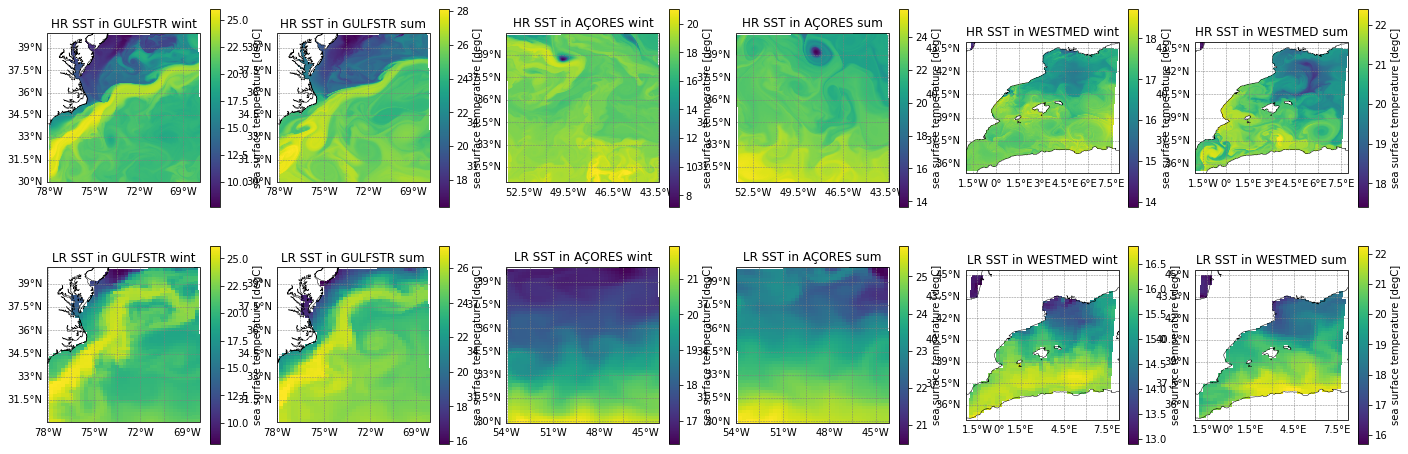

In [23]:
fig, axis = plt.subplots(ncols=len(data), nrows=2, figsize=(24,8), subplot_kw={'projection': ccrs.PlateCarree()})
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['HR', 'LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' SST in ' + data[col]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# "True" density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library:

In [24]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR', 'LR'] :
        # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        # sqr of conservative temperature (to compute the subgrid variance further)
        data[i][dataKey]['sst_sqr'] = data[i][dataKey]['sosstsst']**2
        data[i][dataKey]['sal_sqr'] = data[i][dataKey]['sosaline']**2

CPU times: user 1.15 s, sys: 615 ms, total: 1.76 s
Wall time: 3.67 s


# Filters

## Routines

In [23]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=window_size, y=window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=window_size, y=window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    new_e2t = data['e2t'].coarsen(x=window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'],errors='ignore')
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
#     # binarize and erode the mask (to remove isolated pixels)
#     threshold = 0.0
#     new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
#     result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
#     #apply new mask to data
#     result = result.where(result.tmask>0)
    return result

In [24]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    data = dataHR.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    wet_mask = xr.DataArray(data.tmask, dims=['y','x'])
    area = xr.DataArray((data.e1t * data.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(data.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(data.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(data.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(data.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=data.coords)
        data_filtered = gaussian_filter.apply(data, dims=['y', 'x'])
    else :
        data_filtered =  xr.Dataset({}, coords=data.coords)
        data_filtered = data
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [124]:
coarsening_window_size = 15
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : coarsening_window_size, 'interpolate' : False, 'label' : 'Coarse to 0.25°'}),
           dict({'filter_coef' : 0, 'coarsening_window_size' : int(1.5*coarsening_window_size), 'interpolate' : True, 'label' : 'Coarse to 0.375° + Interp to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : int(2.25*coarsening_window_size), 'interpolate' : True, 'label' : 'Coarse to 0.56° + Interp to 0.25°'}),
          dict({'filter_coef' : 0, 'coarsening_window_size' : int(3.375*coarsening_window_size), 'interpolate' : True, 'label' : 'Coarse to 0.84° + Interp to 0.25°'})]

In [125]:
regrid_method = 'bilinear'

In [126]:
%%time
%%capture --no-display
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = [] 
    ref_data = data[i]['LR']
    out_grid = xr.DataArray(coords={'lon' : ref_data.lon, 'lat' : ref_data.lat, 'x': ref_data.x, 'y': ref_data.y}, dims=['y', 'x'])
    for ifilter, curr_filter in enumerate(filters) :
        filtered = apply_filter_downsample(data[i]['HR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
                                                               chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        if (curr_filter['interpolate']):
            regridder = xe.Regridder(filtered, out_grid, regrid_method, unmapped_to_nan=True)
            regridded = regridder(filtered)
            regridded.coords['e1t'] = ref_data.e1t
            regridded.coords['e2t'] = ref_data.e2t
            data[i]['HR_Filtered'].append(regridded)
        else :
            data[i]['HR_Filtered'].append(filtered)

CPU times: user 40.8 s, sys: 5.95 s, total: 46.8 s
Wall time: 2min 21s


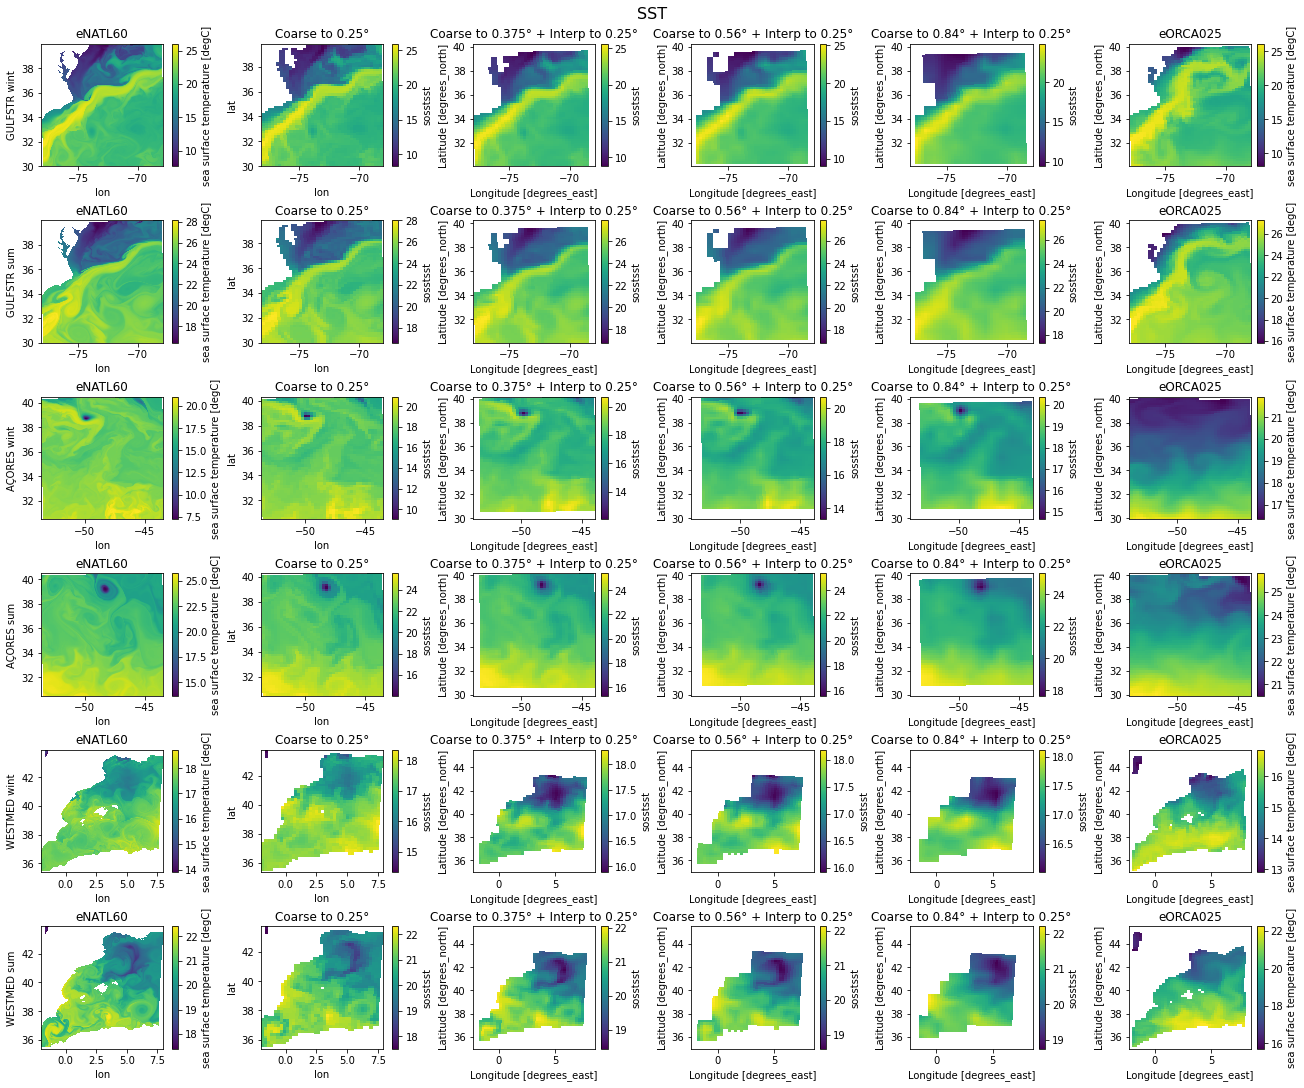

In [128]:
fig, axis = plt.subplots(ncols=6, nrows=6, figsize=(18,15), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('SST', size=16)
for row in range(len(data)) :
    data[row]['HR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0])
    axis[row,0].set(title='eNATL60')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=filters[ifilter]['label'])
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1])
    axis[row,-1].set(title='eORCA025')    
    axis[row,0].set(ylabel=data[row]['label'])

# Compute the subgrid variance and density error

Subgrid variance for temperature and salinity is computed as:
$$ \sigma_T^2 = \overline{T^2} -  \overline{T}^2 $$
$$ \sigma_S^2 = \overline{S^2} - \overline{S}^2 $$

The density error is computed as differene between the density obtained by filtering the HR density and the one evaluated on the basis of filtered temperature and salinity:
$$ \Delta \rho =  \overline{\rho(T,S)} - \rho(\overline{T}, \overline{S}) $$

In [129]:
# density after filtering
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds['sosaline'], ds['sosstsst'], dask='parallelized').compute()

In [130]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] :
        # subgrid temp variance
        ds['var_T'] = ds['sst_sqr'] - ds['sosstsst']**2
        ds['var_S'] = ds['sal_sqr'] - ds['sosaline']**2
        # density correction
        ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']

CPU times: user 446 ms, sys: 3.14 ms, total: 449 ms
Wall time: 447 ms


Compute the second derivatives of the density with the respect to temperature and salinity (known from the EOS)

In [131]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['sosstsst'])

CPU times: user 16 s, sys: 38 ms, total: 16 s
Wall time: 16 s


# Spatial derivatives

In [132]:
def central_diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def central_diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [133]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["diff_T_sqr"] = central_diffs_x(ds['sosstsst'])**2 + central_diffs_y(ds['sosstsst'])**2
        ds["diff_S_sqr"] = central_diffs_x(ds['sosaline'])**2 + central_diffs_y(ds['sosaline'])**2

CPU times: user 2.23 s, sys: 7.55 ms, total: 2.24 s
Wall time: 2.23 s


# Linear regression

In [134]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] :
        ds['predictor_T'] = (0.5*ds['rho_ct_ct']*ds['diff_T_sqr']).compute()
        ds['predictor_S'] = (0.5*ds['rho_sa_sa']*ds['diff_S_sqr']).compute()
        ds['predictor_ST'] = (ds['rho_sa_ct']*np.sqrt(ds['diff_T_sqr']*ds['diff_S_sqr'])).compute()

CPU times: user 5.63 s, sys: 184 ms, total: 5.81 s
Wall time: 15.8 s


In [135]:
model = wrap(sklearn.linear_model.LinearRegression(), sample_dim='sample')

In [136]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] :
        stacked_data = ds[['predictor_T', 'predictor_ST', 'predictor_S', 'sigma0_delta']].stack(sample=("x", "y", "time_counter"))
        stacked_data = stacked_data.where(np.isfinite(stacked_data['predictor_ST']), drop=True)
#        x = xr.concat([stacked_data['predictor_T'], stacked_data['predictor_ST'], stacked_data['predictor_S']], dim="feature").transpose("sample", "feature")
        x = stacked_data['predictor_T'].expand_dims('feature').transpose("sample", "feature")
        y = stacked_data['sigma0_delta']#.expand_dims('feature').transpose("sample", "feature")
        reg = model.fit(x,y)
        ds.attrs['coef_lin_regr_predictor_T'] = reg.coef_[0]
#        ds.attrs['coef_lin_regr_predictor_ST'] = reg.coef_[1]
#        ds.attrs['coef_lin_regr_predictor_S'] = reg.coef_[2]
        
        ds.attrs['coef_lin_regr_score'] = model.score(x,y)

CPU times: user 3.51 s, sys: 78.8 ms, total: 3.59 s
Wall time: 8.4 s


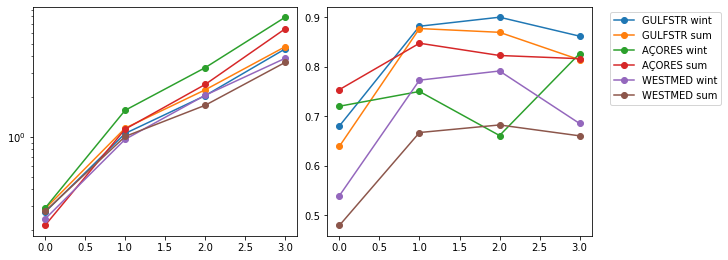

In [140]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,3.5), constrained_layout=True, sharex=True)
for i in range(len(data)) :
    #for col, quantity in enumerate(['predictor_T', 'predictor_ST', 'predictor_S', 'score']) :
    for col, quantity in enumerate(['predictor_T', 'score']) :
        ax[col].plot([data[i]['HR_Filtered'][ifilter].attrs['coef_lin_regr_'+quantity] for ifilter in range(len(filters))], 'o-', label=data[i]['label'])
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set(yscale='log')
plt.show()

# Test resolutions

In [148]:
for i in range(len(data)) : 
    data[i]['HR_coarsened'] = data[i]['HR_Filtered'][0]

In [149]:
coarsening_window_size = 15
tests = [dict({'filter_coef' : 0, 'coarsening_window_size' : int(1.5*coarsening_window_size), 'interpolate' : False, 'label' : 'Coarse to 0.375°'}),
         dict({'filter_coef' : 0, 'coarsening_window_size' : int(2.25*coarsening_window_size), 'interpolate' : False, 'label' : 'Coarse to 0.56°'}),
         dict({'filter_coef' : 0, 'coarsening_window_size' : int(3.375*coarsening_window_size), 'interpolate' : False, 'label' : 'Coarse to 0.84°'})]

In [157]:
%%time
%%capture --no-display
for i in range(len(data)) : 
    data[i]['HR_test'] = [] 
    data[i]['LR_test'] = [] 
    ref_data = data[i]['LR']
    out_grid = xr.DataArray(coords={'lon' : ref_data.lon, 'lat' : ref_data.lat, 'x': ref_data.x, 'y': ref_data.y}, dims=['y', 'x'])
    for ifilter, curr_filter in enumerate(tests) :
#         filtered_HR = apply_filter_downsample(data[i]['HR_coarsened'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
#                                                                chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
#         data[i]['HR_test'].append(filtered_HR)
        
         filtered_LR = apply_filter_downsample(data[i]['LR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute()
         data[i]['LR_test'].append(filtered_LR)

TypeError: operand type(s) all returned NotImplemented from __array_ufunc__(<ufunc 'multiply'>, '__call__', array([[[5.62524284e+08],
        [5.62633492e+08],
        [5.62743150e+08],
        ...,
        [5.66806189e+08],
        [5.66926249e+08],
        [5.67046391e+08]],

       [[5.59484722e+08],
        [5.59597952e+08],
        [5.59711674e+08],
        ...,
        [5.63924505e+08],
        [5.64048983e+08],
        [5.64173591e+08]],

       [[5.56438571e+08],
        [5.56555838e+08],
        [5.56673628e+08],
        ...,
        [5.61037389e+08],
        [5.61166334e+08],
        [5.61295379e+08]],

       ...,

       [[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [4.27377945e+08],
        [4.27712741e+08],
        [4.28047915e+08]],

       [[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [4.24713830e+08],
        [4.25052268e+08],
        [4.25391174e+08]],

       [[0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00],
        ...,
        [           nan],
        [           nan],
        [           nan]]]), dask.array<transpose, shape=(52, 40, 54), dtype=datetime64[ns], chunksize=(52, 40, 4), chunktype=numpy.ndarray>): 'ndarray', 'Array'

CPU times: user 924 ms, sys: 25.7 ms, total: 950 ms
Wall time: 5.03 s
